
After creating a custom model, we have moved to the Transfer Learning technique.
We have tried different pre-trained models:

*   Vgg16
*   ResNet152V2
*   EfficientNetB7
*   EfficientNetB6
*   Xception
*   InceptionResNetV2

At first we have freezed the weights of the models, and we have added the FC layers composed by a Dense layer with 512 neurons and the output layer.
Later, to improve results, we have trained the whole models with the early stopping regularization method; we also performed fine tuning on the learning rate and 
the data augmentation.
Finally we have ensembled the best models by averaging their predictions in order to reduce the overfitting and improve the predictions.
After that we have tried to add another Dense layer in the FC part of the networks with 256 neurons and we have noticed an improvement on the performance especially with EfficientNetB6 and EfficientNetB7 (see next notebook).
In order to achieve better performance we have tried to reduce the validation set to have a bigger training set, but the networks did not improve their results.
In this notebook we show some of our experiments with transfer learning (the checkpoints shown in this notebook can be found at https://drive.google.com/drive/folders/1eymuMxF0REzC0lvVjTA_-tLwPCwlWWSR?usp=sharing).
The final model is composed by the ensemble of: EfficientNetB7 + EfficientNetB6 + Xception + InceptionResNetV2, and can be loaded in the next notebook.


In [ ]:
# This cell is for Colab
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir an2dl_1
%cd an2dl_1
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c artificial-neural-networks-and-deep-learning-2020
!unzip artificial-neural-networks-and-deep-learning-2020.zip

In [39]:
# This cell is for Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import json

import random, re, math
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as L
from tensorflow.keras.applications import ResNet152V2, InceptionResNetV2, InceptionV3, Xception, VGG19, Xception, DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

SEED = 1234
tf.random.set_seed(SEED)  
np.random.seed(SEED)

# Get current working directory
cwd = os.getcwd()


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True
val_split = 0.2
# Create training ImageDataGenerator object
if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(rotation_range=20,
                                        #brightness_range=[-5.0, 5.0],
                                        shear_range=5,
                                        width_shift_range=5,
                                        height_shift_range=5,
                                        zoom_range=[0.95, 1.05],
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='constant',
                                        cval=0,
                                        rescale=1./255,
                                        validation_split=val_split)
else:
    train_data_gen = ImageDataGenerator(rescale=1./255, validation_split=val_split)

# Create validation and test ImageDataGenerator objects
valid_data_gen = ImageDataGenerator(rescale=1./255, validation_split=val_split)   # Don't augment validation split
test_data_gen = ImageDataGenerator(rescale=1./255)

In [4]:
# Create generators to read images from dataset directory
# -------------------------------------------------------
dataset_dir = './MaskDataset'


# Batch size
bs = 2
EPOCHS = 40

# img shape
img_h = 256
img_w = 256
img_size = img_h
num_classes=3

with open(os.path.join(dataset_dir,"train_gt.json")) as f:
  dic = json.load(f)
dataframe = pd.DataFrame(dic.items())
dataframe.rename(columns = {0:'filename', 1:'class'}, inplace = True)
dataframe["class"] = dataframe["class"].astype(str)
dataframe = dataframe.sample(frac=1).reset_index(drop=True)


# Training
training_dir = os.path.join(dataset_dir, 'training')
train_gen = train_data_gen.flow_from_dataframe(dataframe,
                                               training_dir,
                                               batch_size=bs,
                                               target_size=(img_h, img_w),
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED,
                                               subset='training')  # targets are directly converted into one-hot vectors


# Validation
validation_dir = os.path.join(dataset_dir, 'validation')
valid_gen = valid_data_gen.flow_from_dataframe(dataframe,
                                               training_dir,
                                               batch_size=bs, 
                                               target_size=(img_h, img_w),
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED,
                                               subset='validation')


Found 4492 validated image filenames belonging to 3 classes.
Found 1122 validated image filenames belonging to 3 classes.


In [5]:
# Check how keras assigned the labels
train_gen.class_indices

{'0': 0, '1': 1, '2': 2}

In [6]:
# Create Dataset objects
# ----------------------

# Training
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))

# Shuffle (Already done in generator..)
# train_dataset = train_dataset.shuffle(buffer_size=len(train_gen))

# Normalize images (Already done in generator..)
# def normalize_img(x_, y_):
#     return tf.cast(x_, tf.float32) / 255., y_

# train_dataset = train_dataset.map(normalize_img)

# 1-hot encoding <- for categorical cross entropy (Already done in generator..)
# def to_categorical(x_, y_):
#     return x_, tf.one_hot(y_, depth=10)

# train_dataset = train_dataset.map(to_categorical)

# Divide in batches (Already done in generator..)
# train_dataset = train_dataset.batch(bs)

# Repeat
# Without calling the repeat function the dataset 
# will be empty after consuming all the images
train_dataset = train_dataset.repeat()

# Validation
# ----------
valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))

# Repeat
valid_dataset = valid_dataset.repeat()

# Test
# ----

tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)


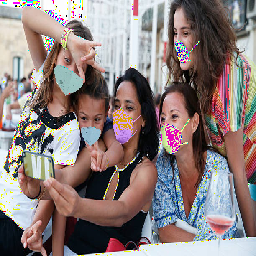

tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)


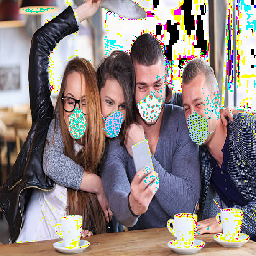

tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)


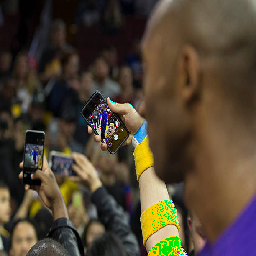

tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)


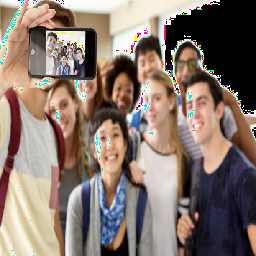

tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)


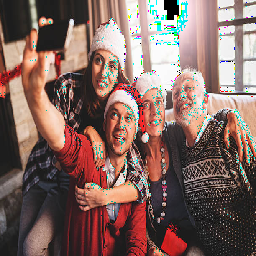

tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)


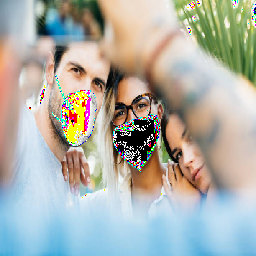

tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)


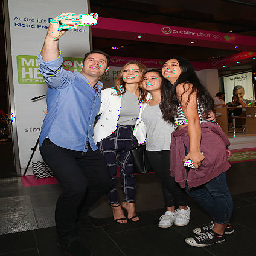

tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)


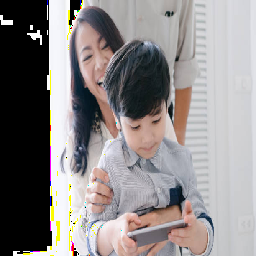

In [7]:
from PIL import Image

valid_iter = iter(valid_dataset)

# Get validation image
for i in range(0, 8):
  valid_img, label = next(valid_iter)
  print(label[0])
  valid_img = valid_img[0]
  Image.fromarray(np.uint8(np.array(valid_img)*256.))

# Visualize the image


tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)


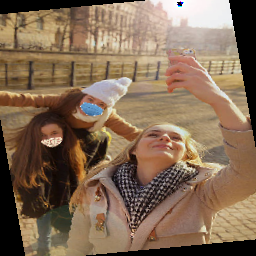

tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)


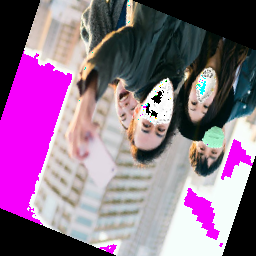

tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)


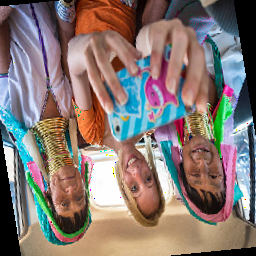

tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)


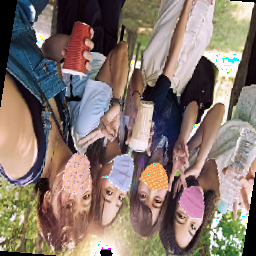

tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)


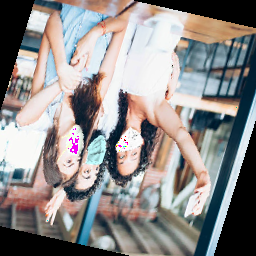

tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)


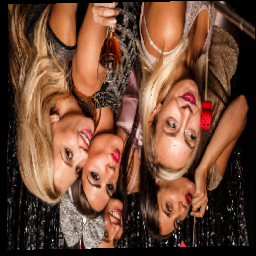

tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)


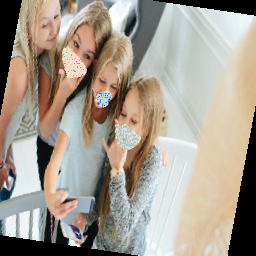

tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)


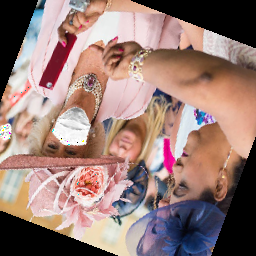

In [8]:
from PIL import Image

train_iter = iter(train_dataset)

# Get training image
for i in range(0, 8):
  train_img, label = next(train_iter)
  print(label[0])
  train_img = train_img[0]
  Image.fromarray(np.uint8(np.array(train_img)*256.))

# Visualize the image


Learning rate schedule: 1e-05 to 0.0001 to 1.01e-05


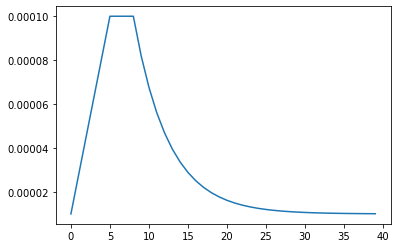

In [9]:
LR_START = 0.00001
LR_MAX = 0.0001 
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 3
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [10]:
def get_model1():
    base_model =  tf.keras.applications.efficientnet.EfficientNetB7(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False, pooling='avg')
    x = base_model.output
    predictions = Dense(num_classes, activation="softmax")(x)
    return Model(inputs=base_model.input, outputs=predictions)

def get_model2():
    base_model =  tf.keras.applications.efficientnet.EfficientNetB6(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False, pooling='avg')
    x = base_model.output
    predictions = Dense(num_classes, activation="softmax")(x)
    return Model(inputs=base_model.input, outputs=predictions)

def get_model3():
    model = tf.keras.Sequential([
        ResNet152V2(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False),
        L.GlobalAveragePooling2D(),
        L.Dense(num_classes, activation='softmax')
    ])
    return model

def get_model4():
    model = tf.keras.Sequential([
        InceptionResNetV2(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False),
        L.GlobalAveragePooling2D(),
        L.Dense(num_classes, activation='softmax')
    ])
    return model

def get_model5():
    model = tf.keras.Sequential([
        Xception(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False),
        L.GlobalAveragePooling2D(),
        L.Dense(num_classes, activation='softmax')
    ])
    return model

In [11]:
# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.CategoricalCrossentropy()

# learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------



In [12]:
#%load_ext tensorboard
#%tensorboard --logdir /content/drive/My\ Drive/Keras3/classification_experiments/

In [13]:
import os
from datetime import datetime


cwd = os.getcwd()

exps_dir = './Classification_experiments'
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'Final'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'Ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'Tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)
#callbacks.append(lr_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    callbacks.append(es_callback)

In [ ]:
# Replace model1 with other models and compile 
model1 = get_model1() 
model1.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model1.fit(train_dataset, 
           steps_per_epoch=len(train_gen), 
           validation_data=valid_dataset,
           validation_steps=len(valid_gen), 
           callbacks=callbacks, 
           epochs=EPOCHS )

In [14]:
# Load models one at time
model1 = get_model1()
model1.load_weights('Classification_experiments/Best_Models/EffB7_Inception_Resnet_Xception_augm_overfit/EfficientNetB7/best.ckpt')
model3 = get_model3()
model3.load_weights('Classification_experiments/Best_Models/EffB7_Inception_Resnet_Xception_augm_overfit/ResNet152V2/best.ckpt')
model4 = get_model4()
model4.load_weights('Classification_experiments/Best_Models/EffB7_Inception_Resnet_Xception_augm_overfit/InceptionResNetV2/best.ckpt')
model5 = get_model5()
model5.load_weights('Classification_experiments/Best_Models/EffB7_Inception_Resnet_Xception_augm_overfit/Xception/best.ckpt')

In [15]:
# Test
res_dir = os.path.join(exp_dir, 'Results')
if not os.path.exists(res_dir):
    os.makedirs(res_dir)
def create_csv(results, results_dir=res_dir):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')


test_dir = os.path.join(dataset_dir, 'test')

images = [f for f in os.listdir(test_dir)]
images = pd.DataFrame(images)
images.rename(columns = {0:'filename'}, inplace = True)
images["class"] = 'test'

test_gen = train_data_gen.flow_from_dataframe(images,
                                              test_dir,
                                              batch_size=bs,
                                              target_size=(img_h, img_w),
                                              class_mode='categorical',
                                              shuffle=False,
                                              seed=SEED)


test_gen.reset()

probs1 = model1.predict_generator(test_gen, len(test_gen),verbose=1)
#probs2 = model2.predict_generator(test_gen, len(test_gen),verbose=1)
probs3 = model3.predict_generator(test_gen, len(test_gen),verbose=1)
probs4 = model4.predict_generator(test_gen, len(test_gen),verbose=1)
probs5 = model5.predict_generator(test_gen, len(test_gen),verbose=1)

probs_avg = (probs1 + probs3 + probs4 + probs5) / 4

results = {}
images = test_gen.filenames
i = 0

for p in probs_avg:
  prediction = np.argmax(p)
  import ntpath
  image_name = ntpath.basename(images[i])
  results[image_name] = str(prediction)
  i = i + 1

create_csv(results)

Found 450 validated image filenames belonging to 1 classes.
Instructions for updating:
Please use Model.predict, which supports generators.
225/225 [==============================] - 7s 30ms/step
